## Relatório GPU


Matheus Freitas Sant'Ana

Neste relatório, será explorado o algoritmo de alinhamento de sequências de DNA, utilizando paralelismo com a GPU & OpenMP como forma de otimizar ao máximo o código. 

#### Inputs necessários

In [2]:
import subprocess
import time
import os
import sys
import matplotlib.pyplot as plt
import random
import statistics
import numpy as np
import pandas as pd

#### Função para rodar o executável e calcular tempo

In [3]:
def roda_com_entrada(executavel, arquivo_in):
    with open(arquivo_in) as f:
        start = time.perf_counter()
        proc = subprocess.run([executavel], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()

        # print('Saída:', proc.stdout)
        # print('Stderr:', proc.stderr)
        # print('Tempo total(s):', end - start)
        f.close()
    return (proc.stdout, end - start)

#### Função para criar entradas

In [4]:
def gerador_entrada(n, m):
    for i in range(0, 10):
        f = open(f'./in-{i}.txt', 'w')
        seq=[str(n)+'\n',
            str(m)+'\n',
            ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
            ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
    f.close()    

#### Configurando permissões dos executáveis

In [7]:
os.chmod("GPU", 0o777)
os.chmod("BuscaExaustiva", 0o777)
os.chmod("ParalelismoExaustiva", 0o777)

### Comando para compilar

Para compilar o arquivo .cu da GPU, utilize o seguinte comando:

`!nvcc -arch=sm_37 -std=c++14 GPU.cu -o GPU`

#### Paralelismo com OpenMP

![outputcode](../Assets/openMP.png "OpenMP").

Uma das estratégias utilzadas para otimizar o algoritmo de sequenciamento foi utilizar a paralelização com OpenMP. Essa biblioteca permite que o código seja paralelizado por meio do lançamento de threads, fazendo o map primeiramente e o reduce no final. 

No contexto do projeto, o cálculo utilizado ainda era o mesmo do da Busca Exaustiva, utilizando a estratégia de Smith Waterman para encontrar o score máximo. Em termos de código, as alterações foram sucintas: apenas a adição de uma linha no loop principal.

`#pragma omp parallel for firstprivate(n, m, H)`

Ou seja, cada thread disponível irá tratar do cálculo do score de um par de subsequências. Vale ressaltar que foi necessário fazer com que a matriz de cálculo `H` fosse um atributo `firstprivate`, para que todas tenham sua própria instância dessa variável, garantindo o score correto. 

Também foi necessário criar um vetor de structs, sendo que cada struct possui três atributos: a subsequência A, a subsequência B e o score. A função de cálculo devolve o score, e ele é atribuído ao seu respectivo struct `result`, sendo que ao final percorre-se o vetor de structs para encontrar o maior score.

Para o cálculo do OpenMP, foram geradas múltiplas entradas com um mesmo tamanho, de tal forma que o cálculo seja rodado diversas vezes para cada n e que se obtenha uma média dos tempos obtidos e por consequência adquirindo um resultado mais confiável. 

In [14]:
tamanhos_OMP = []
media_tempo_OMP = []

tamanhos_BE = []
media_tempo_BE = []

n = 10
m = 10

for i in range(0, 10):
    tempos_OMP = []
    tempos_BE = []
    gerador_entrada(n, m)
    
    for i in range(0, 10):
      tempos_OMP.append(roda_com_entrada('./ParalelismoExaustiva', f'./in-{i}.txt')[1])
      tempos_BE.append(roda_com_entrada('./BuscaExaustiva', f'./in-{i}.txt')[1])

    tamanhos_OMP.append(n)
    media_tempo_OMP.append(statistics.mean(tempos_OMP))

    tamanhos_BE.append(n)
    media_tempo_BE.append(statistics.mean(tempos_BE))
    

    n += 5
    m += 5

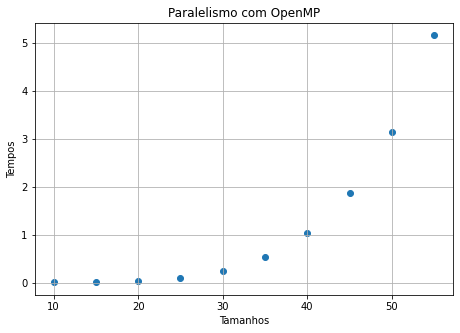

In [ ]:
plt.figure(figsize=(7.5, 5))
plt.scatter(tamanhos_OMP, media_tempo_OMP)
plt.title('Paralelismo com OpenMP')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.grid('on')
plt.show()

Como esse código ainda é uma busca exaustiva, naturalmente ele não roda para tamanhos de sequência muito grandes. Seu desempenho conforme o tamanho aumenta é quase que exponencial, mesmo com o paralelismo. A efeito de comparação, pode-se observar o desempenho dos dois algoritmos abaixo.

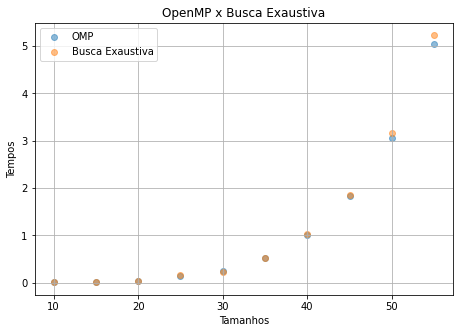

In [15]:
plt.figure(figsize=(7.5, 5))
plt.scatter(tamanhos_OMP, media_tempo_OMP, alpha = 0.5)
plt.scatter(tamanhos_BE, media_tempo_BE, alpha = 0.5)
plt.title('OpenMP x Busca Exaustiva')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.legend(['OMP', 'Busca Exaustiva'])
plt.grid('on')
plt.show()

Pode-se observar que mesmo com o OpenMP, não houve diferença significativa em desempenho em relação ao código sem paralelismo. No entanto, uma leve melhora pode ser observada quando o tamanho de entrada é maior, se demonstrnado como uma melhor opção do que o código bruto da busca exaustiva. Uma possível causa de não haver uma melhoria significativa é o uso do `firstprivate`, que compromete o desempenho do paralelismo.

#### Paralelismo com GPU

![outputcode](../Assets/Stemp.png "Stemp").

Uma maneira de encontrar uma solução ótima global para o problema de alinhamento de sequências é por meio da busca exaustiva, que testa todas as subsequências possíveis e encontra o par com maior alinhamento. No entanto, possui uma complexidade muito alta quando as entradas são grandes. Dessa forma, como maneira de contornar esse problema, é possível utilizar a GPU como forma de paralelismo para o cálculo de score de cada subsequência, ao invés de utilizar apenas a CPU para todo o algoritmo.

Utilizando GPU, a estratégia que originalmente se tinha em mente era de passar uma grande quantidade de dados para a GPU, ou seja, aumentar a vazão de dados e dessa forma alocar o máximo de dados possível na GPU ao mesmo tempo. A CPU é mais rápida para executar instruções, mas quando as instruções são simples ela tem um desempenho pior que o da GPU pois executa sequencialmente, enquanto que a GPU consegue paralelizar seus processos.

Por isso, o cálculo de score de cada par de subsequência foi alterado com o objetivo de obter uma maior vazão de dados. O método de geração de todas as subsequências ainda se mantem o mesmo, de forma sequencial, bem como a forma como elas são percorridas. No entanto, o cálculo não é feito mais utilizando Smith Waterman. O cálculo dentro da GPU realiza a comparação de uma subsequência A com uma letra da subsequência de B, utilizando os mesmos critérios de Smith Waterman. Dessa forma, ao invés de já montar a matriz e realizar o cálculo encontrando o maior valor dela, o cálculo foi alterado de tal forma a ser feito de linha e linha. 

A biblioteca utilizada foi a do thrust, em que um transform com um functor é utilizado para realizar o cálculo descrito acima (essa comparação é a da diagonal e a da inserção), e um inclusive scan para a deleção. Vale ressaltar que a maneira como eram geradas múltiplas entradas para um mesmo `n`foi abdicada aqui devido ao alto tempo de execução do código.

In [12]:
tamanhos_GPU = []
media_tempo_GPU = []

n = 5
m = 5

for i in range(0, 10):
    tempos_GPU = []
    tempos_OMP = []
    gerador_entrada(n, m)
    
    tempos_GPU.append(roda_com_entrada('./GPU', f'./in-{i}.txt')[1])
    
    tamanhos_GPU.append(n)
    media_tempo_GPU.append(statistics.mean(tempos_GPU))

    n += 3
    m += 3

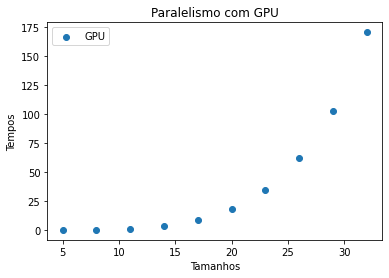

In [18]:
BE = plt.scatter(tamanhos_GPU, media_tempo_GPU)
plt.title('Paralelismo com GPU')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.legend(('GPU', 'OpenMP'))
plt.show()

Pode-se observar que o desempenho da GPU não está bom, para entradas grandes ele demora muito tempo para executar. Uma possível iteração ao projeto poderia ser criar um grande vetor do tipo char que possuiria todas as subsequências de uma sequência 'concatenadas' e outro vetor de índices que faria o controle de faixas para obter reconstruir as subsequências corretas. Dessa forma, seria possível enviar todos os dados de uma vez para a GPU, o que tornaria o desempenho do código muito melhor. No entanto, não foi possível realizar a construção desse algoritmo, pois a biblioteca thrust não permite que funções do tipo host (CPU) sejam utilizadas dentro de functors, impossibilitando o cálculo (Uma tentativa de fazer o código  dessa ideia está no arquivo `tentativa_GPUindex.cu`, dentro da pasta `Paralelismo`, porém o código não foi finalizado).

#### Paralelismo GPU x Paralelismo OpenMP

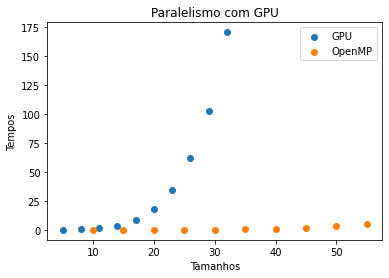

In [17]:
GPU = plt.scatter(tamanhos_GPU, media_tempo_GPU)
BE = plt.scatter(tamanhos_OMP, media_tempo_OMP)
plt.title('Paralelismo com GPU')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.legend(('GPU', 'OpenMP'))
plt.show()

Por fim, ao se comparar o desempenho da GPU com a do OpenMP, a diferença é notória: para entradas de mesmo tamanho, como 30 por exemplo, já se pode notar como o desempenho do código do OpenMP é superior. Para entradas pequenas a diferença é quase que inexistente.